# Прогнозирование удоя коров и вкуса молока на основе линейной и логистической регрессий

Владелец молочного хозяйства `«Вольный луг»` хочет расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ `«ЭкоФерма»`, условия позволяют ему тщательно отобрать коров. Фермер хочет, чтобы каждая корова давала не менее 6000 килограммов молока в год, а её надой был вкусным (качество молока заказчик определяет по собственной методике).
Требуется разработать модель машинного обучения, которая поможет фермеру управлять рисками и принимать объективное решение о покупке. Нужно построить две прогнозные модели для отбора коров:  
- для прогноза возможного удоя коровы (целевой признак `Удой`);  
- для определения вероятности получить вкусное молоко от коровы (целевой признак `Вкус молока`).  

**Цель:** отобрать коров по двум критериям:  
- средний `удой` за год — `не менее 6000 килограммов`;  
- `молоко` должно быть `вкусным`.  

В нашем распоряжении три набора данных.  
Датасет `ferma_main` предоставлен заказчиком и содержит информацию о стаде фермера, а именно:  
- Характеристики коров (`id`, `порода`, `порода папы быка`, `возраст`);  
- Характеристики корма коров  (`Энергетическая Кормовая Единица (питательность корма)`, `Сахаро_Ппротеиновое Отношение`, `Содержание сырого протеина`);  
- Характеристики молока (`Жирность`, `Содержание белка`, `Удой, кг`, `Вкус`);  
- Характеристики пастбища (`тип пастбища`).  

Второй набор данных `ferma_dad` содержит имя папы каждой коровы в стаде фермера (`id`, `имя папы быка`).  

Третий датасет предоставлен «ЭкоФермой», это данные о коровах, которых фермер хочет изучить перед покупкой:  
- `Порода`;  
- `Тип пастбища`;  
- `Порода папы_быка`;  
- `Имя папы`;  
- `Текущая_жирность`;  
- `Текущий уровень белка`;  
- `Возраст`.



## Загрузка данных

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

RANDOM_STATE = 42

In [ ]:
try:
    ferma = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
    dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
    buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
except:
    ferma = pd.read_csv('ferma_main.csv', sep=';', decimal=',')
    dad = pd.read_csv('ferma_dad.csv', sep=';', decimal=',')
    buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')

In [ ]:
display(ferma.head())
display(dad.head())
display(buy.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Определим функцию для вывода основной информации о датасете

In [ ]:
def data_info(df):
    display(df.head(20))
    print()
    display(df.describe())
    print()
    print(df.info())

In [ ]:
data_info(ferma)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возра

In [ ]:
data_info(dad)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


In [ ]:
data_info(buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


,"Текущая_жирность,%","Текущий_уровень_белок,%"
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None


Необходимо переименовать столбцы, так как они содержат знаки препинания, пробелы, буквы разного регистра. Типы данных указаны корректно, пропущенных значений не обнаружено.

##  Предобработка данных

### Изменение названий признаков

Выведем столбцы датасета `ferma_main`:

In [ ]:
ferma.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

Сделаем столбец `id` индексами строк датафрейма

In [ ]:
ferma.set_index('id', inplace=True)

Переимением столбцы: приведём к нижнему регистру и удалим знаки препинания и пробелы.

In [ ]:
ferma = ferma.rename(columns={
    'Удой, кг':'удой',
    'ЭКЕ (Энергетическая кормовая единица)':'эке',
    'Сырой протеин, г':'сырой_протеин',
    'СПО (Сахаро-протеиновое соотношение)':'спо',
    'Порода':'порода',
    'Тип пастбища':'тип_пастбища',
    'порода папы_быка':'порода_папы',
    'Жирность,%':'жирность',
    'Белок,%':'белок',
    'Вкус молока':'вкус',
    'Возраст':'возраст'
})

ferma.columns

Index(['удой', 'эке', 'сырой_протеин', 'спо', 'порода', 'тип_пастбища',
       'порода_папы', 'жирность', 'белок', 'вкус', 'возраст'],
      dtype='object')

Аналогично обработаем названия столбцов в `cow_buy` и `ferma_dad`.

In [ ]:
buy.columns

Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')

In [ ]:
buy = buy.rename(columns={
    'Порода':'порода',
    'Тип пастбища':'тип_пастбища',
    'порода папы_быка':'порода_папы',
    'Имя_папы':'имя_папы',
    'Текущая_жирность,%':'текущая_жирность',
    'Текущий_уровень_белок,%':'текущий_белок',
    'Возраст':'возраст'
})

buy.columns

Index(['порода', 'тип_пастбища', 'порода_папы', 'имя_папы', 'текущая_жирность',
       'текущий_белок', 'возраст'],
      dtype='object')

In [ ]:
dad.columns

Index(['id', 'Имя Папы'], dtype='object')

In [ ]:
dad = dad.rename(columns={
    'Имя Папы':'имя_папы'
})

dad.columns

Index(['id', 'имя_папы'], dtype='object')

### Обработка дубликатов

Выведем уникальные значения категориальных признаков в `ferma_main`:

In [ ]:
for i in ['порода', 'тип_пастбища', 'порода_папы', 'вкус', 'возраст']:
    print(f'Уникальные значения признака "{i}":')
    print(ferma[i].unique())
    print()

Уникальные значения признака "порода":
['Вис Бик Айдиал' 'РефлешнСоверинг']

Уникальные значения признака "тип_пастбища":
['Равнинное' 'Равнинные' 'Холмистое']

Уникальные значения признака "порода_папы":
['Айдиал' 'Соверин' 'Айдиалл']

Уникальные значения признака "вкус":
['вкусно' 'не вкусно']

Уникальные значения признака "возраст":
['более_2_лет' 'менее_2_лет']



Есть повторяющиеся значения с различным написанием в столбцах `тип_пастбища` и `порода_папы`, приведём их к одному виду:

In [ ]:
ferma['тип_пастбища'] = ferma['тип_пастбища'].replace('Равнинные', 'Равнинное')
ferma['порода_папы'] = ferma['порода_папы'].replace('Айдиалл', 'Айдиал')

Оценим количество явных дубликатов в датасете и удалим их:

In [ ]:
print(f'Количество явных дубликатов (ferma): {ferma.duplicated().sum()}')

Количество явных дубликатов (ferma): 5


In [ ]:
ferma = ferma.drop_duplicates()

Проведём аналогичную проверку для `cow_buy`:

In [ ]:
for i in ['порода', 'тип_пастбища', 'порода_папы', 'имя_папы', 'возраст']:
    print(f'Уникальные значения признака "{i}":')
    print(buy[i].unique())
    print()

Уникальные значения признака "порода":
['Вис Бик Айдиал' 'РефлешнСоверинг']

Уникальные значения признака "тип_пастбища":
['холмистое' 'равнинное']

Уникальные значения признака "порода_папы":
['Айдиал' 'Соверин']

Уникальные значения признака "имя_папы":
['Геркулес' 'Буйный' 'Барин' 'Соловчик']

Уникальные значения признака "возраст":
['более_2_лет' 'менее_2_лет']



Для удобства дальнейшего кодирования категориальных переменных, приведём значения признаков в `cow_buy` к тому же виду, что и в `ferma_main`:

In [ ]:
buy['тип_пастбища'] = buy['тип_пастбища'].replace('холмистое','Холмистое').replace('равнинное','Равнинное')

In [ ]:
print(f'Количество явных дубликатов (buy): {buy.duplicated().sum()}')

Количество явных дубликатов (buy): 4


In [ ]:
buy = buy.drop_duplicates()

In [ ]:
print('Уникальные значения признака "имя_папы":', dad['имя_папы'].unique())

Уникальные значения признака "имя_папы": ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


In [ ]:
print(f'Количество явных дубликатов (dad): {dad.duplicated().sum()}')

Количество явных дубликатов (dad): 0


### Промежуточный вывод:
В ходе предобработки данных были изменены названия признаков, удалены явные дубликаты, а также повторяющиеся значения категориальных переменных.

## Исследовательский анализ данных

### Анализ количественных признаков

Определим функцию для визуализации распределений количественных признаков и вывода описательной статистики

In [ ]:
def num_features_stats(feature, feature_name, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    # Гистограмма
    ax[0].hist(feature, bins=15)
    ax[0].set_title(f'Распределение данных')
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid()

    # Диаграмма размаха
    ax[1].boxplot(feature, vert=False)
    ax[1].set_title(f'Диаграмма размаха')
    ax[1].set_xlabel(feature_name)
    ax[1].grid()

    plt.show()

    print()
    print('Описательная статистика')
    print(feature.describe())


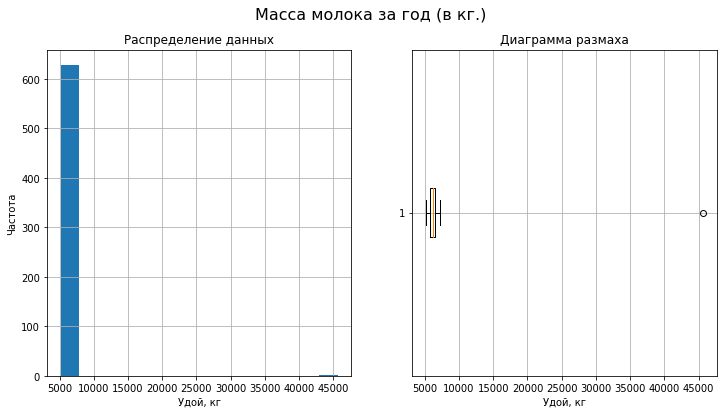


Описательная статистика
count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой, dtype: float64


In [ ]:
num_features_stats(ferma['удой'], 'Удой, кг', 'Масса молока за год (в кг.)')

Есть аномально большое значение 45 616 кг. молока за год, при этом нет дпугих значений, превышающих 10 000. Выведем это наблюдение:

In [ ]:
ferma.query('удой > 10000')

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус,возраст
id,,,,,,,,,,,
17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


Так как среди 629 наблюдений обнаружен 1 выброс, можем удалить его.

In [ ]:
ferma = ferma.query('удой < 10000')

Повторно визуализируем распределение:

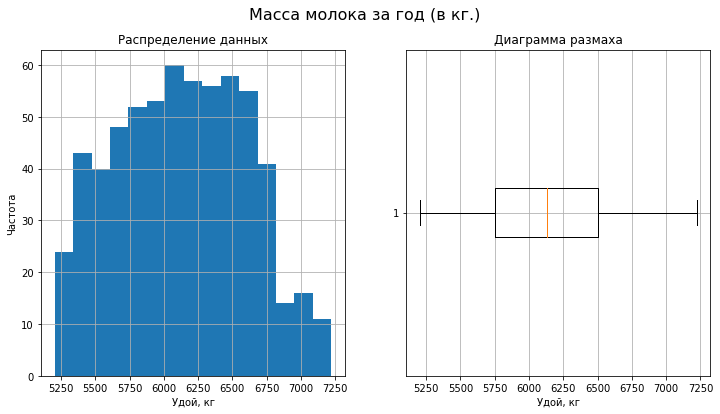


Описательная статистика
count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой, dtype: float64


In [ ]:
num_features_stats(ferma['удой'], 'Удой, кг', 'Масса молока за год (в кг.)')

В среднем коровы дают 6 126 кг. молока в год, при этом лишь у 25% коров удой превышает 6 500 кг.

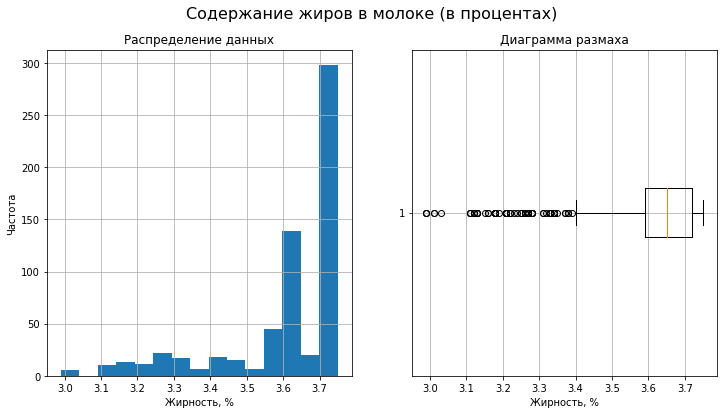


Описательная статистика
count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64


In [ ]:
num_features_stats(ferma['жирность'], 'Жирность, %', 'Содержание жиров в молоке (в процентах)')

Распределение данных, предоставленных фермером, по `жирности` молока имеет выраженный пик и смещенно вправо. Большая часть коров (75%) даёт молоко с процентом `жирности` от 3,59 до 3,75, остальные 25% распределены от 2,99 до 3,59.

Сравним с распределением данных в наборе данных `ЭкоФермы`:

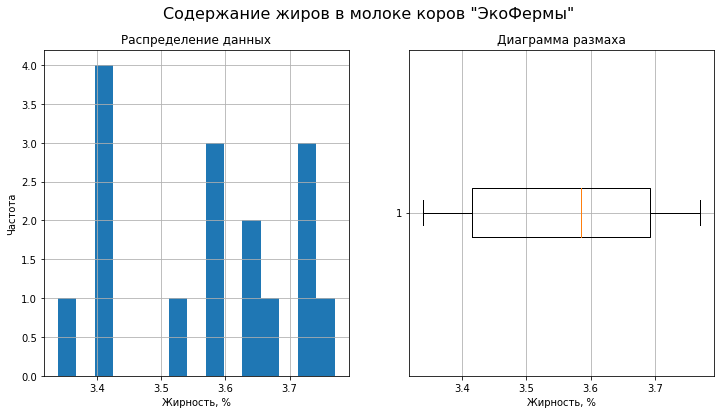


Описательная статистика
count    16.000000
mean      3.571875
std       0.141620
min       3.340000
25%       3.415000
50%       3.585000
75%       3.692500
max       3.770000
Name: текущая_жирность, dtype: float64


In [ ]:
num_features_stats(buy['текущая_жирность'], 'Жирность, %', 'Содержание жиров в молоке коров "ЭкоФермы"')

In [ ]:
print('Количество коров ЭкоФермы, жирность молока которых составляет:')
print('- [3,3 ; 3,4) - ', (buy['текущая_жирность'] < 3.4).sum())
print('- [3,4 ; 3,5) - ', ((buy['текущая_жирность'] >= 3.4) & (buy['текущая_жирность'] < 3.5)).sum())
print('- [3,5 ; 3,6) - ', ((buy['текущая_жирность'] >= 3.5) & (buy['текущая_жирность'] < 3.6)).sum())
print('- [3,6 ; 3,7) - ', ((buy['текущая_жирность'] >= 3.6) & (buy['текущая_жирность'] < 3.7)).sum())
print('- [3,7 ; 3,8) - ', ((buy['текущая_жирность'] >= 3.7) & (buy['текущая_жирность'] < 3.8)).sum())

Количество коров ЭкоФермы, жирность молока которых составляет:
- [3,3 ; 3,4) -  1
- [3,4 ; 3,5) -  4
- [3,5 ; 3,6) -  4
- [3,6 ; 3,7) -  3
- [3,7 ; 3,8) -  4


Жирность молока коров, которых фермер рассматривает для покупки, распределена более равномерно и составляет в основном от 3,4% до 3,8%.

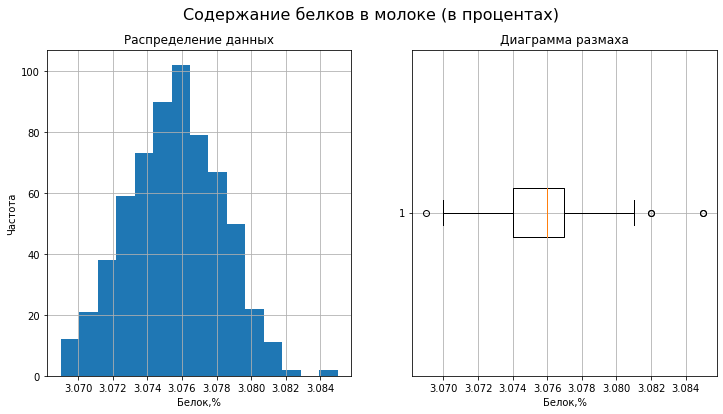


Описательная статистика
count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64


In [ ]:
num_features_stats(ferma['белок'], 'Белок,%', 'Содержание белков в молоке (в процентах)')

Данные о содержании `белка` в молоке распределены нормально, среднее значение составляет 3,076 и почти совпадает с медианой. Даграмма размаха свидетельствует о наличии выбросов (3.069, 3.082, 3.085), однако учитывая диапазон распределения основной массы наблюдений (от 3.07 до 3.081), эти значения выглядят правдоподобно, не будем удалять их.

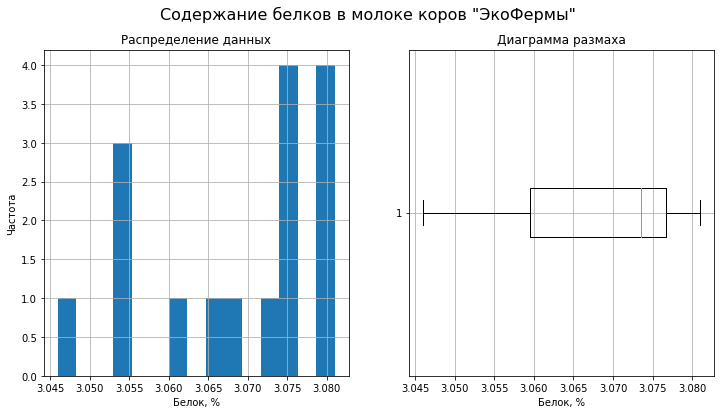


Описательная статистика
count    16.000000
mean      3.068250
std       0.011264
min       3.046000
25%       3.059500
50%       3.073500
75%       3.076750
max       3.081000
Name: текущий_белок, dtype: float64


In [ ]:
num_features_stats(buy['текущий_белок'], 'Белок, %', 'Содержание белков в молоке коров "ЭкоФермы"')

In [ ]:
print('Количество коров ЭкоФермы с процентным содержанием белка в молоке в диапазоне:')
print('- [3,04 ; 3,05) - ', (buy['текущий_белок'] < 3.05).sum())
print('- [3,05 ; 3,06) - ', ((buy['текущий_белок'] >= 3.05) & (buy['текущий_белок'] < 3.06)).sum())
print('- [3,06 ; 3,07) - ', ((buy['текущий_белок'] >= 3.06) & (buy['текущий_белок'] < 3.07)).sum())
print('- [3,07 ; 3,08) - ', ((buy['текущий_белок'] >= 3.07) & (buy['текущий_белок'] < 3.08)).sum())
print('- [3,08 ; 3,09) - ', ((buy['текущий_белок'] >= 3.08) & (buy['текущий_белок'] < 3.09)).sum())

Количество коров ЭкоФермы с процентным содержанием белка в молоке в диапазоне:
- [3,04 ; 3,05) -  1
- [3,05 ; 3,06) -  3
- [3,06 ; 3,07) -  3
- [3,07 ; 3,08) -  8
- [3,08 ; 3,09) -  1


Половина коров ЭкоФермы даёт молоко, содержащее 3,07% - 3,08% белка.

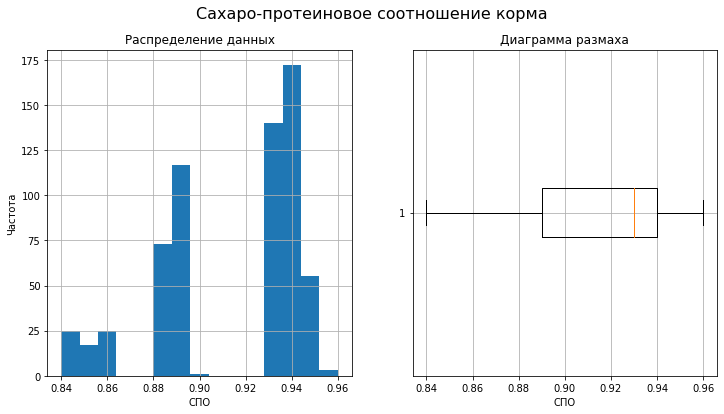


Описательная статистика
count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64


In [ ]:
num_features_stats(ferma['спо'], 'СПО', 'Сахаро-протеиновое соотношение корма')

Распределение данных по `сахаро-протеиновому соотношению` корма имеет мультимодальное распределение, наблюдения разделены на три группы. Возможно, потребуется категоризировать переменную, но пока оставим без изменений.  
Причинами такого распределения могут быть различные нормы данного показателя в зависимости от возраста, массы коровы и прочих индивидуальных характеристик.

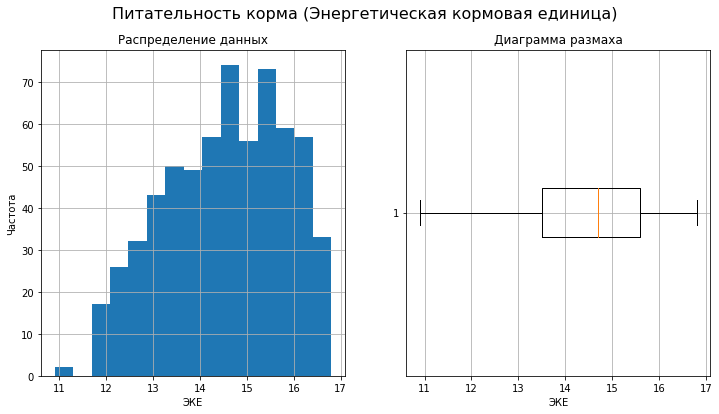


Описательная статистика
count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64


In [ ]:
num_features_stats(ferma['эке'], 'ЭКЕ', 'Питательность корма (Энергетическая кормовая единица)')

`Энергетическая кормовая единица`, характеризующая питательность корма, в среднем составляет 14,55, при для 75% коров `ЭКЕ` корма больше 13,5.

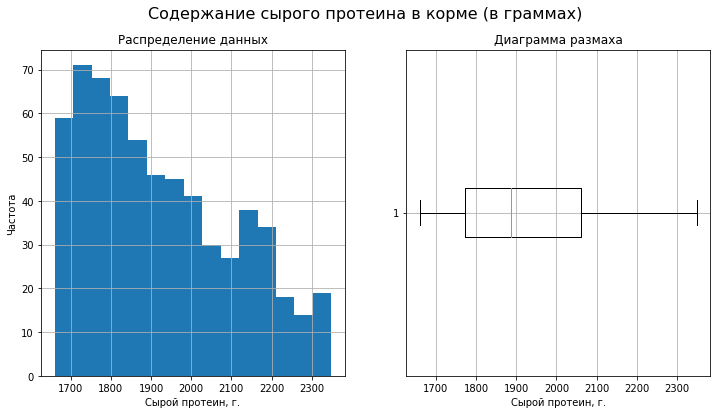


Описательная статистика
count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: сырой_протеин, dtype: float64


In [ ]:
num_features_stats(ferma['сырой_протеин'], 'Сырой протеин, г.', 'Содержание сырого протеина в корме (в граммах)')

В корме большей части коров содержится от 1,6 до 2 кг. `сырого протеина`. Медианное значение данного покателя составляет 1,89 кг.

Определим функцию для визуализации распределений категориальных признаков.

In [ ]:
def cat_features_stats(feature, feature_name, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    ax[0].bar(feature.value_counts(ascending=False).index,
              feature.value_counts(ascending=False).values)
    ax[0].set_title('Столбчатая диаграмма')
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel('Количество наблюдений')

    ax[1].pie(feature.value_counts(ascending=False),
              autopct='%1.1f%%',labels=feature.value_counts(ascending=False).index,
              wedgeprops = { 'linewidth' : 3,
                         'edgecolor' : 'white' })
    ax[1].set_title('Круговая диаграмма')
    ax[1].set_ylabel(None)

    plt.show()

Сравним распределения данных о коровах фермера и ЭкоФермы:

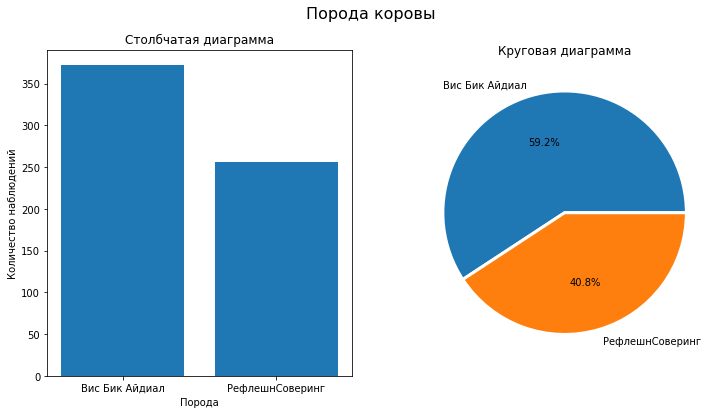

In [ ]:
cat_features_stats(ferma['порода'], 'Порода', 'Порода коровы')

В датасете фермера в большем количестве представлены коровы породы `Вис Бик Айдиал`, коров `РефлешнСоверинг` на 18,4% меьше.

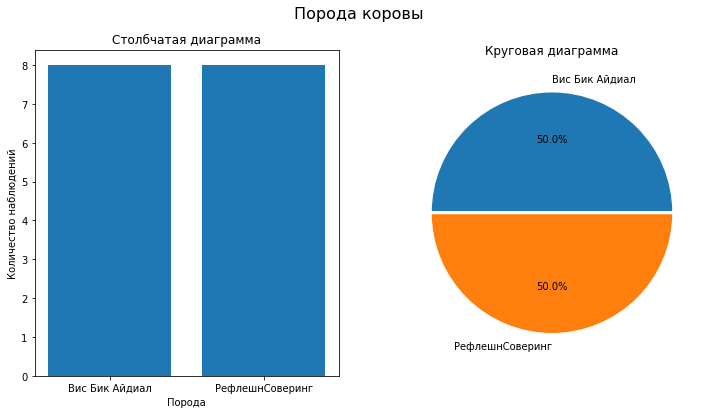

In [ ]:
cat_features_stats(buy['порода'], 'Порода', 'Порода коровы')

Перед покупкой фермер хочет изучить равное количество коров обеих пород.

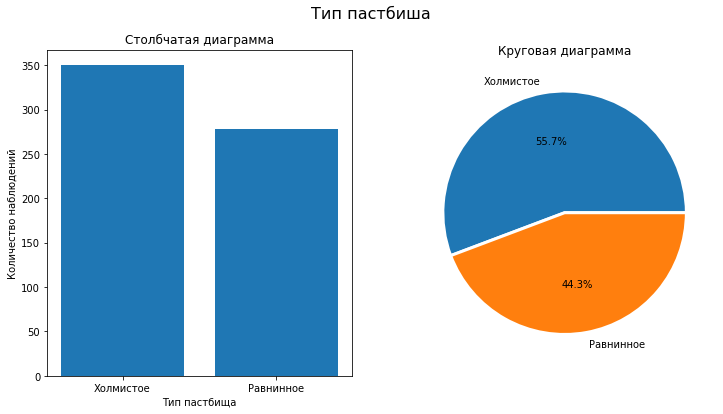

In [ ]:
cat_features_stats(ferma['тип_пастбища'], 'Тип пастбища', 'Тип пастбиша')

55,7% фермера пасутся на холмистых пастбищах, это на 11,4% больше, чем на равнинных.

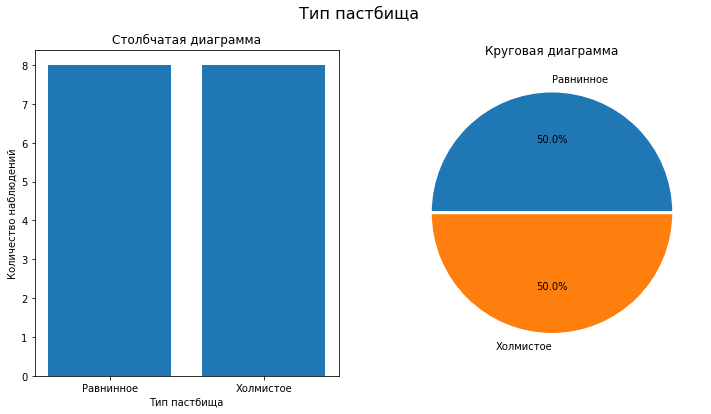

In [ ]:
cat_features_stats(buy['тип_пастбища'], 'Тип пастбища', 'Тип пастбища')

Коровы, рассматриваемые для покупки, в равных количествах пасутся как на холмистых, так и на равнинных пастбищах.

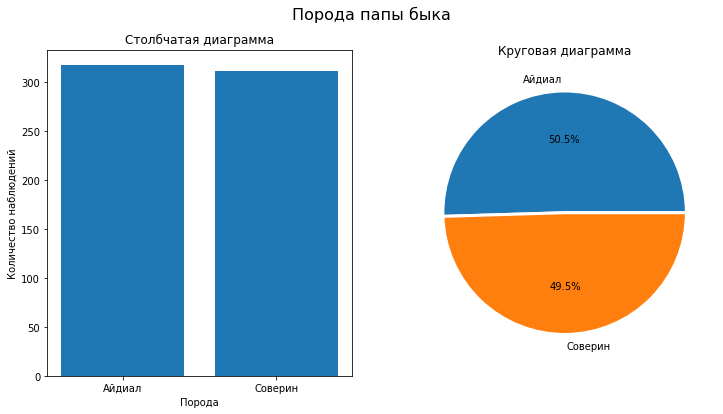

In [ ]:
cat_features_stats(ferma['порода_папы'], 'Порода', 'Порода папы быка')

В стаде фермера примерно равное количество потомков быков пород `Айдиал` и `Соверин`.

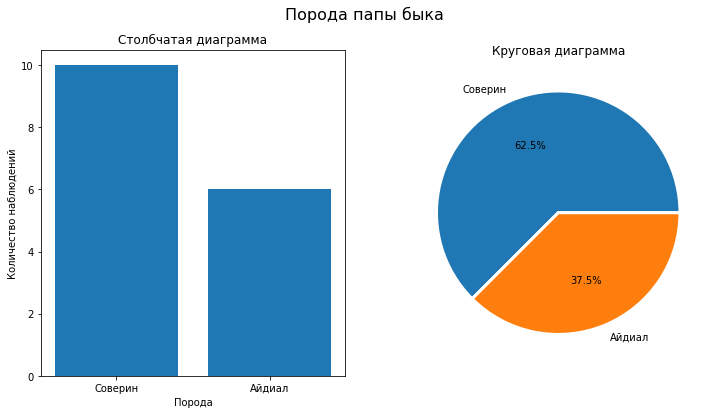

In [ ]:
cat_features_stats(buy['порода_папы'], 'Порода', 'Порода папы быка')

В наборе данных, предназначенном для прогноза, преобладают дети быков породы `Соверин` (62,5), их на 25% больше, чем дочерей `Быков Айдиал` (37,5).

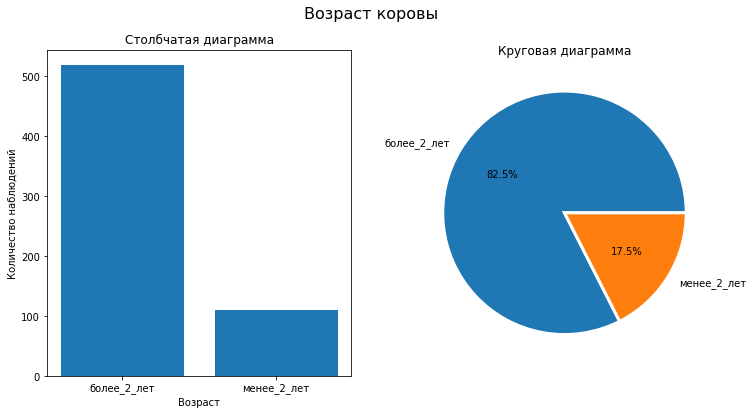

In [ ]:
cat_features_stats(ferma['возраст'], 'Возраст', 'Возраст коровы')

Большинство коров фермера (82,5%) старше 2 лет.

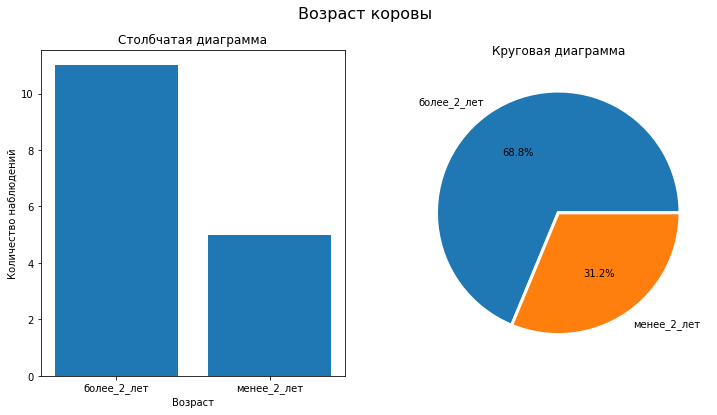

In [ ]:
cat_features_stats(buy['возраст'], 'Возраст', 'Возраст коровы')

Для покупки фермер рассматривает, также, преимущественно взрослых коров (68,8% старше 2 лет).

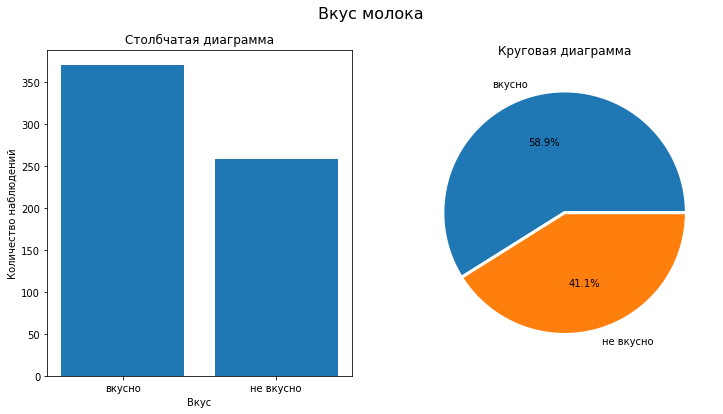

In [ ]:
cat_features_stats(ferma['вкус'], 'Вкус', 'Вкус молока')

58.9% коров даёт молоко, соответствующее критериям вкуса, разработанным фермером.

### Промежуточный вывод

В среднем за год коровы дают 6 125 - 6 135 кг. `молока за год`, в 58,9% случаев оно `вкусное`.  

Молоко большей части коров содержит  от 3,6 до 3,75% `жиров` и от 3,07 до 3,077% `белков`.  

На ферме заказчика преобладают коровы породы `Вис Бик Айдиал` в возрасте `более 2 лет`.  

Пасутся коровы почти в равной степени как на `холмистых`, так и на `равнинных` `пастбищах`.  

В стаде фермера в равном количестве представлены коровы - дети быков породы `Айдиал` и `Соверин`,   
однако для покупки заказчик рассматривает в большей степени дочерей быклв породы `Соверин`.  

При дальнейшем анализа следует обратить внимание на признак `СПО (сахаро-протеиновое соотнощение)`. Возможно, он потребует дополнительной обработки, потому что наблюдения по нему разделились на группы.

## Корреляционный анализ

### Коррелограмма

Для построения прогноза удоя коров сначала изучим взаимосвязь между признаками. Для этого построим коррелограмму.

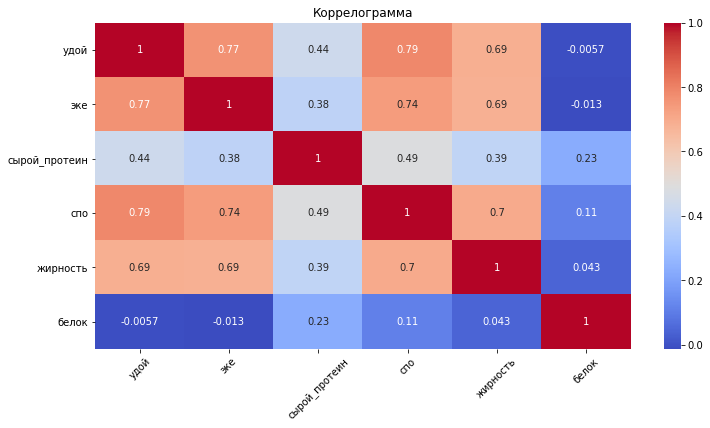

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(ferma.select_dtypes([int, float]).corr(method='spearman'),
            annot=True,
            cmap='coolwarm')
plt.title('Коррелограмма')
plt.xticks(rotation=45)
plt.show();

Наблюдается высокая степень линейной зависимости `удоя` от `сахаро-протеинового отношения` и `энергетической кормовой единицы`. Также,  отмечается заметная взаимосвязь между `жирностью` молока и `удоем`, однако маловероятно, что этот признак определяет количество молока за год, поскольку `жирность` измеряется в уже собранном молоке.  

Стоит отметить высокую степень корреляции между `СПО` и `ЭКЕ` (0,74), однако связь обоих признаков с целевой переменной (0,79 и 0,77) выше. При этом связь между `СПО` и `жирностью` (0,7) немного выше, чем между `жирностью` и `удоем` (0.69).  Это может свидетельствовать о том, что сахаро-протеиновое отношение в значительной степени объясняет содержание жиров в молоке.  
Перед построением модели линейной регрессии проверим, нет ли в данных мультиколлинеарности, поскольку она приводит к нестабильности коэффициентов модели. Это происходит, когда одна из независимых переменных может быть выражена через другие входные признаки, что затрудняет оценку их индивидуального влияния.  
Для этого воспользуемся коэффициентом инфляции дисперсии VIF из библиотеки statsmodels

In [ ]:
# выделение количественных признаков и добавление константы
X = add_constant(ferma.select_dtypes([int, float]).drop('удой', axis=1))

# расчет VIF для каждого признака
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

VIFs['VIF'] = VIFs['VIF'].round(3)

print(VIFs)

        Variable          VIF
0          const  1565939.698
1            эке        2.570
2  сырой_протеин        1.343
3            спо        2.646
4       жирность        1.876
5          белок        1.079


Для всех количественных признаков значение VIF меньше 5, мультиколлинеарности не обнаружено.

### Диаграммы рассеяния

Построим диаграммы рассеяния удоя и всех количественных признаков с учётом значений категориальных переменных. Для удобства определим функцию.

In [ ]:
def scatter_milk_weight(feature, feature_name):
    cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст']

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    plt.suptitle(f'Диаграмма рассения для признаков: "Удой" и "{feature_name}"', fontsize=16)

    for i, name in enumerate(cat_col_names):
        ax = axs[i // 2, i % 2]

        sns.scatterplot(
            data=ferma, x=feature, y='удой', hue=name, ax=ax)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Удой, кг')

    plt.show();

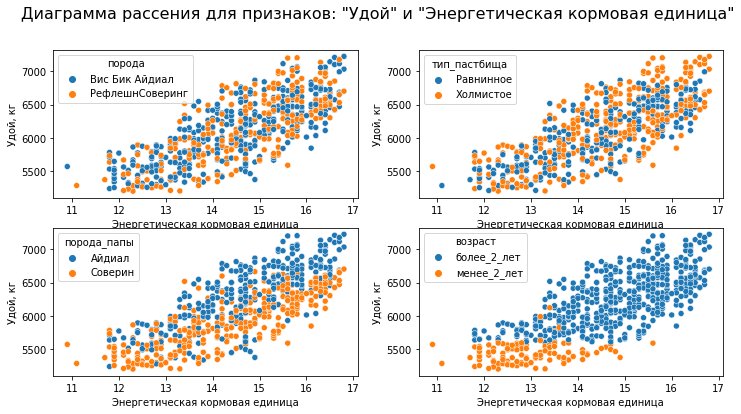

In [ ]:
scatter_milk_weight('эке', 'Энергетическая кормовая единица')

Несмотря на высокое значение коэффициента корреляции (0,77), сложно однозначно назвать зависимость `удоя` от `ЭКЕ` линейной, однако можно заметить зависимость количества молока за год от `возраста` коровы, а так же проследить разделение данных по признаку `порода папы`.  

Проверим, какой признак лучше описывает вариацию `удоя`: `ЭКЕ` или `ЭКЕ в квадрате`:

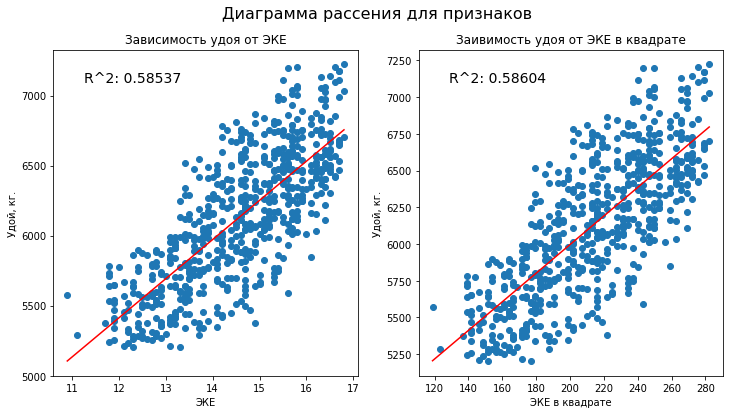

In [ ]:
# Отбираем признаки ЭКЕ и ЭКЕ в квадрате и преобразовываем в двумерные массивы (для обучения регрессии)
eke = ferma['эке'].values.reshape(-1, 1)
eke_sq = ferma['эке'] ** 2
eke_sq = eke_sq.values.reshape(-1, 1)
milk_weight = ferma['удой']

# Обучаем регрессию для ЭКЕ в квадрате и удоя
regression_eke = LinearRegression().fit(eke, milk_weight)
regression_eke_sq = LinearRegression().fit(eke_sq, milk_weight)

# Вычисление коэффициента детерминации (R^2)
r2_eke = regression_eke.score(eke, milk_weight)
r2_eke_sq = regression_eke_sq.score(eke_sq, milk_weight)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Диаграмма рассения для признаков', fontsize=16)

# Вычисляем координаты линии регрессии для удоя и ЭКЕ
X_plot_eke = np.linspace(eke.min(), eke.max(), 100).reshape(-1, 1)
y_plot_eke = regression_eke.predict(X_plot_eke)

# для удоя и ЭКЕ в квадрате
X_plot_eke_sq = np.linspace(eke_sq.min(), eke_sq.max(), 100).reshape(-1,1)
y_plot_eke_sq = regression_eke_sq.predict(X_plot_eke_sq)

# Построение диаграммы рассеяния для ЭКЕ и удоя
ax[0].scatter(x=eke, y=milk_weight)
ax[0].plot(X_plot_eke, y_plot_eke, color='red')
ax[0].set_title('Зависимость удоя от ЭКЕ')
ax[0].set_xlabel('ЭКЕ')
ax[0].set_ylabel('Удой, кг.')
ax[0].text(0.1, 0.9, 'R^2: ' + str(round(r2_eke, 5)),
           transform=ax[0].transAxes, fontsize=14)

# Даиграмма рассеяния для ЭКЕ в квадрате и удоя
ax[1].scatter(x=eke_sq, y=milk_weight)
ax[1].plot(X_plot_eke_sq, y_plot_eke_sq, color='red')
ax[1].set_title('Заивимость удоя от ЭКЕ в квадрате')
ax[1].set_xlabel('ЭКЕ в квадрате')
ax[1].set_ylabel('Удой, кг.')
ax[1].text(0.1, 0.9, 'R^2: ' + str(round(r2_eke_sq, 5)),
           transform=ax[1].transAxes, fontsize=14)

plt.show()

Коэффициент детерминации для `ЭКЕ в квадрате` немного выше (на 0,00067), чем для `ЭКЕ`, это говорит о том, что такой показатель может чуть лучше объяснять дисперсию `удоя`. Но учитывая, что различия в коэффициенте детерминации небольшие, следует проверить оба признака при обучении моделей.

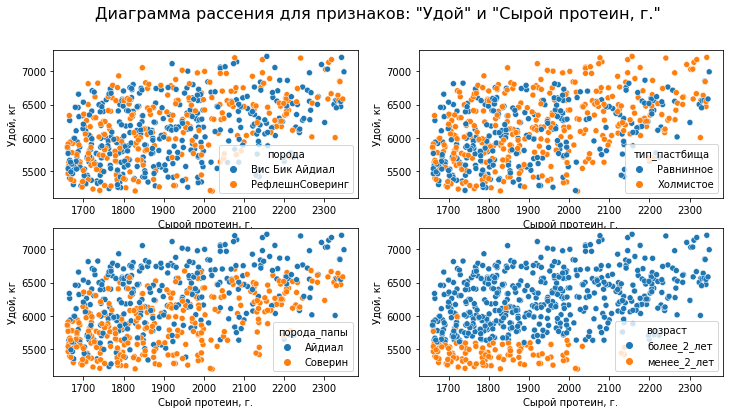

In [ ]:
scatter_milk_weight('сырой_протеин', 'Сырой протеин, г.')

Линейной зависимости не обнаружено, а разделение оп возрасту по-прежнему ярко выражено.

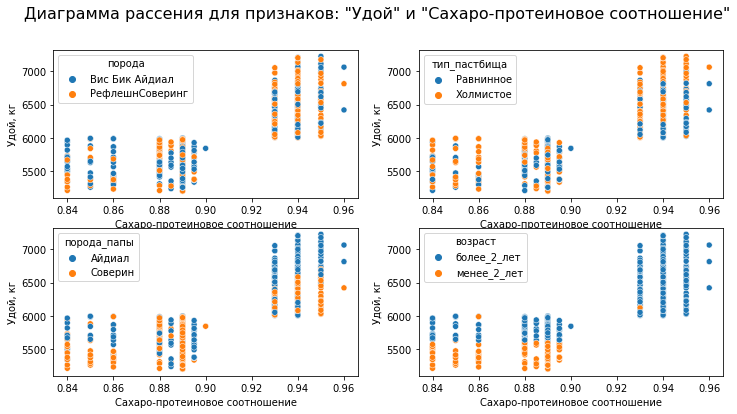

In [ ]:
scatter_milk_weight('спо', 'Сахаро-протеиновое соотношение')

Зависимость между `удоем` и `СПО` нелинейна, наблюдения разделены на кластеры.   

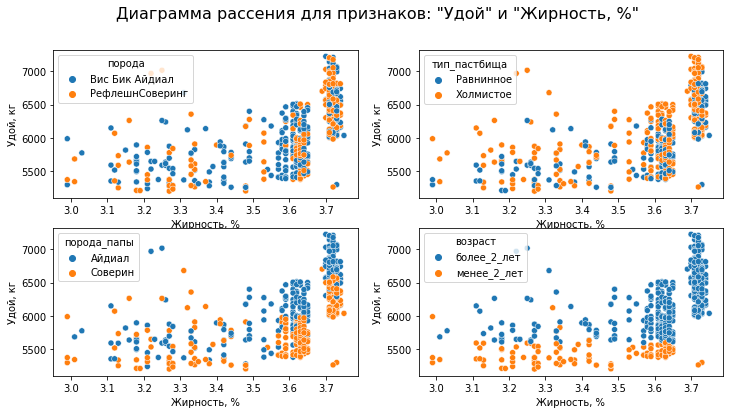

In [ ]:
scatter_milk_weight('жирность', 'Жирность, %')

Разделение наблюдений по `породе папы быка` не такое выраженное, как по `возрасту`, однако стоит обатить внимание на этот признак.

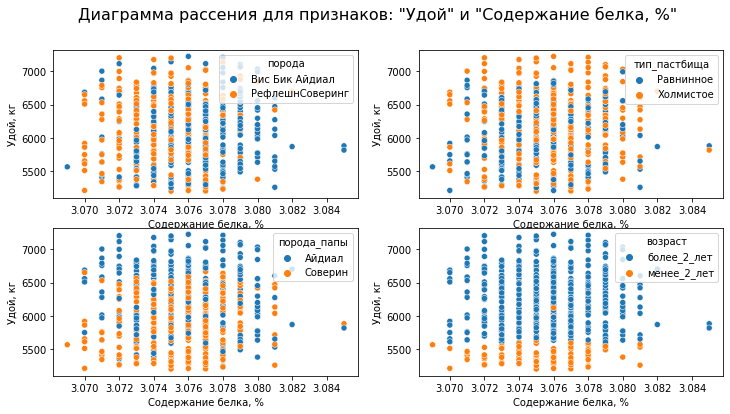

In [ ]:
scatter_milk_weight('белок', 'Содержание белка, %')

Линейной зависимости между `удоем` и `содержанием белка` не обнаружено.

Сгруппируем данные по категориальным признакам и посмотрим на различия в удое по группам.

In [ ]:
ferma.groupby('возраст')['удой'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
возраст,,,,
более_2_лет,5601,7222,6270.735521,6267.0
менее_2_лет,5204,6122,5444.245455,5435.5


Коровы `младше 2 лет` в среднем за год дают на 827 кг. молока меньше, чем взрослые коровы. Максимальный `удой` коров `старше 2 лет` на 900 кг. в год превышает анлогичный показатель для коров младшего возраста.

In [ ]:
ferma.groupby('порода_папы')['удой'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
порода_папы,,,,
Айдиал,5242,7222,6310.899054,6370
Соверин,5204,6701,5937.469453,5919


`Удой` коров в зависимости от `породы папы быка` действительно различается. Потомки быков породы `Айдиал` дают в среднем на 374 кг. молока в год больше, а медианный `удой` на 451 кг. превышает аналогичный показатель для породы быка `Соверин`.

In [ ]:
ferma.groupby('порода')['удой'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
порода,,,,
Вис Бик Айдиал,5242,7222,6099.405914,6112.0
РефлешнСоверинг,5204,7201,6164.566406,6178.5


In [ ]:
ferma.groupby('тип_пастбища')['удой'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
тип_пастбища,,,,
Равнинное,5213,6991,6056.287770,6061
Холмистое,5204,7222,6181.314286,6171


По `породе коровы` и `типу пастбища` различия не столь существенны.

### Промежуточный вывод

Наиболее тесная связь отмечается между `удоем` и мледующими признаками:  

- `Энергетическая кормовая единица`;  
- `Сахаро-протеиновое отношение`;  
- `Возраст`;  
- `Порода папы быка`.  

При этом связь с `ЭКЕ` и `СПО` нелинейна, поэтому потребуется дополнительная обработка этих признаков для включения их в модель линейной регрессии.

## Обучение модели линейной регрессии

Построим модель линейной регрессии для прогнозирования удоя.  
Для первой модели отберём признаки описаясь не только на результаты корреляционного анализа, но и на причинно-следственные связи между группами признаков. Целесообразно включить характеристики коровы (`возраст`, `порода` `порода папы`), корма (`ЭКЕ`, `сырой протеин`, `СПО`) и пастбища (`тип пастбища`). Характеристики молока (`жирность`, `белок`, `вкус`) вряд ли окажут влияние на удой.

In [ ]:
X = ferma[['эке','сырой_протеин', 'спо', 'возраст', 'порода_папы', 'порода', 'тип_пастбища']].copy()
y = ferma['удой']

### Определение собственных функций

Определим функцию для подготовки данных и обучения модели

In [ ]:
def linear_model(X, y, cat_col_names, num_col_names):

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    # Обучаем энкодер и кодируем признаки тренировочной выборки
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_encoded = encoder.fit_transform(X_train[cat_col_names])
    # Кодируем признаки тестовой выборки
    X_test_encoded = encoder.transform(X_test[cat_col_names])

    # Обучаем скелер и масштабируем данные
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    # Объединяем данные
    X_train = pd.concat([
        pd.DataFrame(X_train_scaled, columns=num_col_names),
       pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names())],
                       axis=1)

    X_test = pd.concat([
        pd.DataFrame(X_test_scaled, columns=num_col_names),
        pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names())],
                       axis=1)

    # Обучаем модель линейной регрессии
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    # Получаем предсказанные значения удоя
    y_pred = lr_model.predict(X_test)

    return encoder, scaler, lr_model, y_test, y_pred

Для удобства определим функцию для визуализации остатков и подсчёта метрик качества модели

In [ ]:
def metrics_and_errors(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    errors = y_test - y_pred

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle('Остатки модели линейной регрессии', fontsize=16)

    ax[0].hist(errors, bins=25)
    ax[0].set_title('Распределение остатков')
    ax[0].set_xlabel('Остатки модели')
    ax[0].set_ylabel('Частота')
    ax[0].grid()

    sns.scatterplot(
        x=y_pred, y=errors, ax=ax[1])
    ax[1].set_title('Диаграмма рассеяния')
    ax[1].set_xlabel('Предсказанные значения')
    ax[1].set_ylabel('Остатки модели')

    plt.show()
    print()
    print('Оценки качества модели')
    print('MAE:', round(mae, 3))
    print('MSE:', round(mse, 3))
    print('RMSE:', round(rmse, 3))
    print('R^2:', round(r2, 3))

### Модель линейной регрессии №1

Подготовим данные и обучим модель линейной регрессии для отобранных признаков

In [ ]:
encoder_1, scaler_1, lr_model_1, y_test, y_pred = linear_model(
    X=X,
    y=y,
    cat_col_names=['возраст', 'порода_папы', 'порода', 'тип_пастбища'],
    num_col_names=['эке','сырой_протеин', 'спо']
)

Выведем распределение остатков модели и оценки её качества

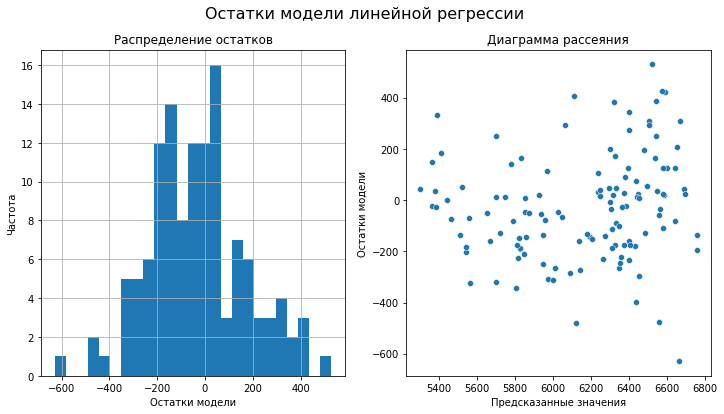


Оценки качества модели
MAE: 161.124
MSE: 42393.462
RMSE: 205.897
R^2: 0.796


In [ ]:
metrics_and_errors(y_test, y_pred)

Распределение остатков близко к нормальному, но немного смещенно влево, разброс достаточно постоянен, ошибки модели распределены вокруг нуля, никаких закономерностей с остатках не прослеживается. Коэффициент детерминации составляет 0,796, полученная модель ошибается в 20,4% случаев.  
Скорректируем модель, опираюсь на результаты корреляционного анализа: так как была обнаружена нелинейная зависимость между `удоем` и признаками `ЭКЕ` и `СПО`, введём новые переменные, чтобы устранить нелинейность:  
- возведём `ЭКЕ` в квадрат,  
- категоризируем признак `СПО`: на даиграмме рассеяния значение 0,92 разделяло наблюдения на 2 кластера, поэтому выделим две группы коров: жирность молока которых >= 0,92 и < 0,92.  

Из категориальных признаков включим `возраст` и `породу папы быка`.

### Модель линейной регрессии №2

In [ ]:
X = ferma[['эке', 'спо', 'возраст', 'порода_папы']].copy()
y = ferma['удой']

X['спо'] = X['спо'].apply(lambda x: 1 if x >= 0.92 else 0)
X['эке_кв'] = X['эке'] ** 2
X = X.drop(columns='эке')

In [ ]:
encoder_2, scaler_2, lr_model_2, y_test, y_pred = linear_model(
    X=X,
    y=y,
    cat_col_names=['спо', 'возраст', 'порода_папы'],
    num_col_names=['эке_кв']
)

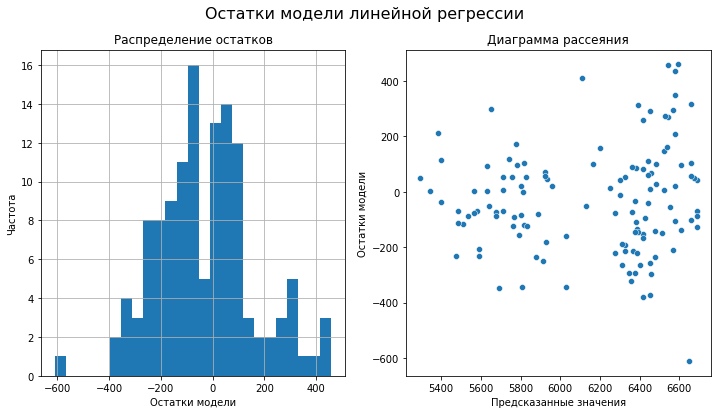


Оценки качества модели
MAE: 151.365
MSE: 36711.666
RMSE: 191.603
R^2: 0.823


In [ ]:
metrics_and_errors(y_test, y_pred)

Распределение остатков немного сместилось к 0, однако стало более выраженным разделение ошибок на две группы (на диаграмме рассеяния в районе прогнозных 6000 - 6100, а на гистограмме чётче прослеживаются два пика). При этом коэффициент детерминации вырос на 2,7%, сократились средняя абсолютная ошибка, средняя квадратичная и корень среднеквадратичной ошибки.  
Дополним датафрейм переменной `имя папы быка` и включим её в модель.

### Модель линейной регрессии №3

In [ ]:
ferma = ferma.merge(dad, on='id')

Проверим, не образовалось ли пропущенных значений

In [ ]:
ferma.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             628 non-null    int64  
 1   удой           628 non-null    int64  
 2   эке            628 non-null    float64
 3   сырой_протеин  628 non-null    int64  
 4   спо            628 non-null    float64
 5   порода         628 non-null    object 
 6   тип_пастбища   628 non-null    object 
 7   порода_папы    628 non-null    object 
 8   жирность       628 non-null    float64
 9   белок          628 non-null    float64
 10  вкус           628 non-null    object 
 11  возраст        628 non-null    object 
 12  имя_папы       628 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.7+ KB


In [ ]:
X = ferma[['эке', 'спо', 'возраст', 'порода_папы', 'имя_папы']].copy()
y = ferma['удой']

X['спо'] = X['спо'].apply(lambda x: 1 if x >= 0.92 else 0)
X['эке_кв'] = X['эке'] ** 2
X = X.drop(columns='эке')

In [ ]:
encoder_3, scaler_3, lr_model_3, t_test, y_pred = linear_model(
    X=X,
    y=y,
    cat_col_names=['спо', 'возраст', 'порода_папы', 'имя_папы'],
    num_col_names=['эке_кв']
)

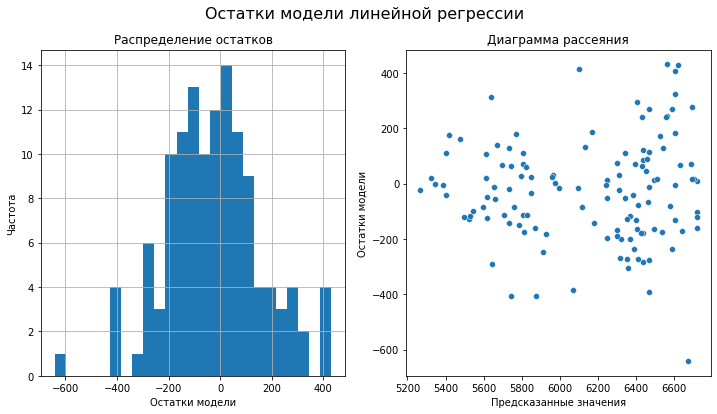


Оценки качества модели
MAE: 143.929
MSE: 34616.137
RMSE: 186.054
R^2: 0.833


In [ ]:
metrics_and_errors(y_test, y_pred)

Распределение приблизилось к нормальному, разброс стал чуть более равномерным, коэффицент детерминации увеличился ещё на 1%, а MAE, MSE и RMSE сократились. Однако в данной модели учтены и признак `имя папы быка`, и  `порода папы быка`. Целесообразнее оставить одну из эти переменных, и так как мы уже строили регрессию с `породой папы быка`, исключим её.

### Модель линейной регрессии №4

In [ ]:
X = ferma[['эке', 'спо', 'возраст', 'имя_папы']].copy()
y = ferma['удой']

X['спо'] = X['спо'].apply(lambda x: 1 if x >= 0.92 else 0)
X['эке_кв'] = X['эке'] ** 2
X = X.drop(columns='эке')

In [ ]:
encoder_4, scaler_4, lr_model_4, y_test, y_pred = linear_model(
    X=X,
    y=y,
    cat_col_names=['спо', 'возраст', 'имя_папы'],
    num_col_names=['эке_кв']
)

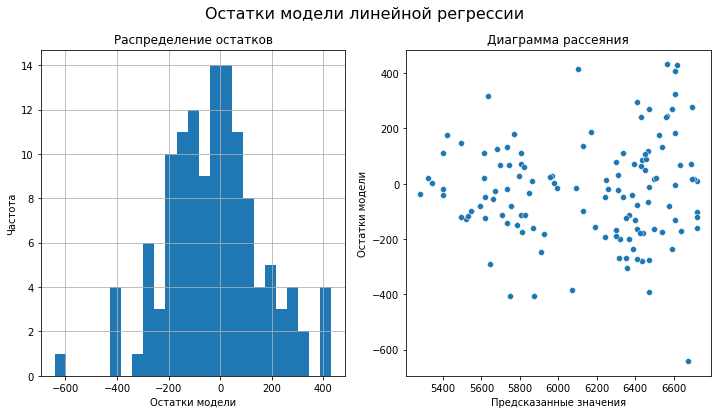


Оценки качества модели
MAE: 144.152
MSE: 34571.217
RMSE: 185.933
R^2: 0.833


In [ ]:
metrics_and_errors(y_test, y_pred)

Коэффициент детерминации не изменился, он составляет 0,833, модель ошибается в 16,7% случаев, при этом у неё наименьшие средние абсолютная и квадратичная ошибки, а также корень и квадратичной ошибки. Остатки распределены нормально, график достаточно симметричен и центр близок к 0, в разбросе остатков нет выраженных закономерностей.  
Данная модель является оптимальной среди рассмотренных.

### Доверительный интервал

Рассчитаем доверительный интервал для прогноза. Для этого определим процентили ошибок:

In [ ]:
lower_quantile = np.percentile(y_test - y_pred, 2.5)
upper_quantile = np.percentile(y_test - y_pred, 97.5)

Теперь определим границы доверительного интервала

In [ ]:
lower_bound = y_pred + lower_quantile
upper_bound = y_pred + upper_quantile

In [ ]:
print(f'Доверительный интервал: prediction - {-lower_quantile:.2f} ; prediction + {upper_quantile:.2f}')

Доверительный интервал: prediction - 390.34 ; prediction + 396.89


На 95% уровне доверия можно утверждать, что истинное значение удоя окажется в интервале от (-390,3; +396,9) от точечного прогноза.

In [ ]:
predictions = pd.DataFrame((y_pred, lower_bound, upper_bound), index=['прогноз', 'нижняя граница', 'верхняя граница']).T

In [ ]:
predictions

,прогноз,нижняя граница,верхняя граница
0,5977.448733,5587.107065,6374.335666
1,6496.318454,6105.976786,6893.205387
2,5519.627055,5129.285387,5916.513988
3,5659.104913,5268.763245,6055.991846
4,5912.523143,5522.181475,6309.410076
...,...,...,...
121,5544.437232,5154.095564,5941.324165
122,6720.739878,6330.398210,7117.626811
123,6298.711133,5908.369465,6695.598066
124,6339.515012,5949.173344,6736.401945


### Прогноз удоя

Теперь можно спрогнозировать удой для коров ЭкоФермы, которые рассматриваются для покупки. Для этого сначала подготовим датасет.

In [ ]:
buy.head(5)

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


В наобре данных ЭкоФермы отсутсвуют данные о питательности корма (`ЭКЕ`) и сахаро-протеиновом отношении (`СПО`). Заполним эти столбцы, увеличив на 5% средние `ЭКЕ` и `СПО` из датасета фермера (поскольку в документации к наборам данных указано, что для новых коров планируется увеличить значения этих параметров на 5%).

In [ ]:
buy['спо'] = ferma['спо'].mean()*1.05
buy['эке'] = ferma['эке'].mean()*1.05

In [ ]:
buy_model = buy[['эке', 'спо', 'возраст', 'имя_папы']].copy()

In [ ]:
buy_model['спо'] = buy_model['спо'].apply(lambda x: 1 if x >= 0.92 else 0)
buy_model['эке_кв'] = buy_model['эке'] ** 2
buy_model = buy_model.drop(columns='эке')

In [ ]:
buy_model.columns

Index(['спо', 'возраст', 'имя_папы', 'эке_кв'], dtype='object')

Так как энкодер и скелер уже обучены, простро применим их к выборке `ЭкоФермы`

In [ ]:
buy_model_encoded = encoder_4.transform(buy_model[['спо', 'возраст', 'имя_папы']])

buy_model_scaled = scaler_4.transform(buy_model[['эке_кв']])

In [ ]:
buy_model = pd.concat([
    pd.DataFrame(buy_model_scaled, columns=['эке_кв']),
    pd.DataFrame(buy_model_encoded, columns=encoder_4.get_feature_names())],
                    axis=1)

In [ ]:
milk_weight_pred = lr_model_4.predict(buy_model)

In [ ]:
lower_bound = milk_weight_pred + lower_quantile
upper_bound = milk_weight_pred + upper_quantile

In [ ]:
milk_weight = pd.DataFrame((milk_weight_pred, lower_bound, upper_bound), index=['прогноз', 'нижняя граница', 'верхняя граница']).T
milk_weight

,прогноз,нижняя граница,верхняя граница
0,6555.034555,6164.692887,6951.921488
1,6336.665307,5946.323639,6733.552240
2,6308.994677,5918.653009,6705.881610
3,6548.447107,6158.105439,6945.334040
4,6548.447107,6158.105439,6945.334040
5,6343.252755,5952.911087,6740.139688
6,6548.447107,6158.105439,6945.334040
7,6336.665307,5946.323639,6733.552240
8,6338.601661,5948.259993,6735.488594
9,6555.034555,6164.692887,6951.921488


### Промежуточный вывод

Точечный прогноз для всех коров оказался больше 6000 кг. молока, однако для половины из них нижняя граница доверительного интервала меньше желаемого значения. Следовательно, покупка этих коров сопровождается риском: существует вероятность, что эти коровы могут произвести меньше молока, чем требуется фермеру, что может повлиять на прибыльность хозяйства.

## Обучение модели логистической регрессии

Приступим к построению модели логистической регресси для прогнозирования вкуса молока. Для этого вновь проверим корреляционную матрицу, но как для количественных, так и для категориальных переменных.

In [ ]:
# Загрузим необходимую библиотеку
!pip install phik

### Подготовка данных

interval columns not set, guessing: ['id', 'удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']


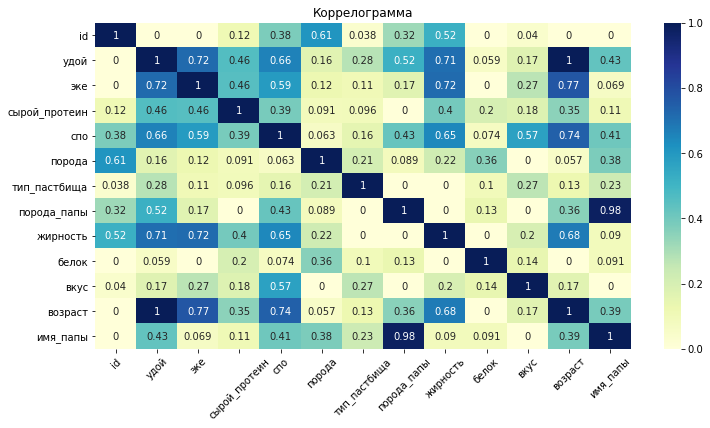

In [ ]:
import phik

plt.figure(figsize=(12,6))
sns.heatmap(ferma.phik_matrix(),
            annot=True,
            cmap='YlGnBu')
plt.title('Коррелограмма')
plt.xticks(rotation=45)
plt.show();

Между `возрастом` и `удоем` очень высокая степень корреляции, близкая к 1, а также 0,98 между `именем и породой папы`. В данных есть мультиколлинеарность; для того, чтобы её устранить, удалим признаки `удой` (поскольку количество молока вряд ли оказывает влияние на его вкус) и `порода папы` (так как переменной `имя папы` будет достаточно).

In [ ]:
X = ferma.drop(columns=['id', 'удой', 'порода_папы', 'вкус'])
y = ferma['вкус'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [ ]:
# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [ ]:
cat_col_names = ['порода', 'тип_пастбища', 'возраст', 'имя_папы']

# Кодируем категориальные переменные
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_encoded = encoder.fit_transform(X_train[cat_col_names])
X_test_encoded = encoder.transform(X_test[cat_col_names])

In [ ]:
num_col_names = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [ ]:
# Объединяем
X_train = pd.concat([
    pd.DataFrame(X_train_scaled, columns=num_col_names),
    pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names())],
                    axis=1)

X_test = pd.concat([
    pd.DataFrame(X_test_scaled, columns=num_col_names),
    pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names())],
                   axis=1)

### Обучение модели логистической регрессии

Инициализируем модель логистической регрессии

In [ ]:
logistic_model = LogisticRegression()

Обучаем модель и предсказываем целевую переменную

In [ ]:
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

### Оценка качества логистической регрессии

Рассчитываем оценки качества модели классификации

In [ ]:
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 3)}')
print(f'Recall: {round(recall_score(y_test, y_pred), 3)}')
print(f'Precision: {round(precision_score(y_test, y_pred), 3)}')

Accuracy: 0.587
Recall: 0.808
Precision: 0.608


Точность модели невысокая, в том числа метрика `precision` (имеющая важное значение в данном случае) имеет низкое значение 0,608.  
Выведем матрицу ошибок:

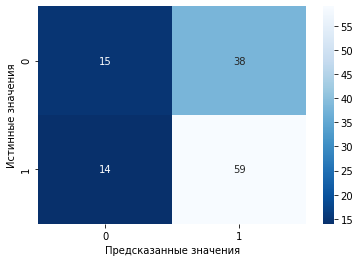

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения');

В данном случае ошибка первого рода критичнее: если мы предскажем, что корова будет давать вкусное молоко и ошибёмся, фермер потратит деньги на покупку, а качество молоко не будет соответствовать заявленным требованиям. В результате фермер не получит ожидаемой прибыли и может столкнуться с финансовыми потерями.  
Чтобы этого не допустить, необходимо свести к 0 ошибку первого рода.

### Определение порога отнесения к классам

In [ ]:
# Определим вероятности отнесения наблюдений к классам
y_proba = logistic_model.predict_proba(X_test)[:,1]

In [ ]:
prob = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'y_proba': y_proba
    }).sort_values(by='y_proba',ascending=False)

In [ ]:
prob.head(10)

,y_test,y_pred,y_proba
597,1,1,0.839644
56,1,1,0.826234
63,1,1,0.817287
287,1,1,0.809830
587,0,1,0.805332
286,0,1,0.803700
188,1,1,0.795624
281,1,1,0.786214
244,1,1,0.786002
456,1,1,0.781879


Ложноположительный ответ впервые встречается для наблюдения с вероятностью отнесения к классу 1 равной 0,805. Следовательно нужно повысить порог до 0,806:

In [ ]:
y_pred_0_806 = (logistic_model.predict_proba(X_test)[:,1] > 0.806).astype(int)

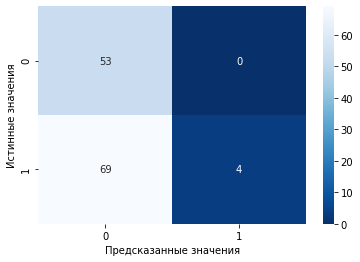

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_0_806), annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения');

In [ ]:
print(f'Accuracy: {round(accuracy_score(y_test, y_pred_0_806), 3)}')
print(f'Recall: {round(recall_score(y_test, y_pred_0_806), 3)}')
print(f'Precision: {round(precision_score(y_test, y_pred_0_806), 3)}')

Accuracy: 0.452
Recall: 0.055
Precision: 1.0


Ошибка первого рода сведена к 0, а оценка `Precision` стала равна 1, метрика `Recall` при этом сильно ухудшилась, однако таким образом мы свели к минимуму риски.

### Прогноз вкуса молока по модели логистической регрессии

Теперь на основе полученной модели построим прогноз.  
Для этого проведём аналогичную подготовку данных.

In [ ]:
buy['эке'] = 1.05 * ferma['эке'].mean()
buy['сырой_протеин'] = 1.05 * ferma['сырой_протеин'].mean()
buy['спо'] = 1.05 * ferma['спо'].mean()

Заменим названия столбцов на идентичные тем, что были в обучающей выборке.

In [ ]:
buy = buy.rename(columns={'текущая_жирность':'жирность',
                          'текущий_белок':'белок'})

In [ ]:
buy.columns

Index(['порода', 'тип_пастбища', 'порода_папы', 'имя_папы', 'жирность',
       'белок', 'возраст', 'спо', 'эке', 'сырой_протеин'],
      dtype='object')

In [ ]:
X = buy.drop(columns='порода_папы')

In [ ]:
cat_col_names = ['порода', 'тип_пастбища', 'возраст', 'имя_папы']

X_encoded = encoder.transform(X[cat_col_names])

num_col_names = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

X_scaled = scaler.transform(X[num_col_names])

In [ ]:
X = pd.concat([
    pd.DataFrame(X_scaled, columns=num_col_names),
    pd.DataFrame(X_encoded, columns=encoder.get_feature_names())],
                    axis=1)

In [ ]:
y_pred = logistic_model.predict(X)

In [ ]:
y_pred

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1])

При пороге отнесения к классу 1, равному 0,5, 11 коров из 16 дадут вкусное молокр. Изменим порог:

In [ ]:
y_pred_0_806 = (logistic_model.predict_proba(X)[:,1] > 0.81).astype(int)

In [ ]:
y_pred_0_806

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

После изменения порога лишь 1 корова даст вкусное молоко.

## Объединение результатов

In [ ]:
buy['вкус_прогноз'] = y_pred_0_806
buy['удой_прогноз'] = milk_weight_pred

In [ ]:
buy['вкус_прогноз'] = buy['вкус_прогноз'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
buy['нижняя_границы'] = buy['удой_прогноз'] + lower_quantile
buy['верхняя_граница'] = buy['удой_прогноз'] + upper_quantile

In [ ]:
buy

,порода,тип_пастбища,порода_папы,имя_папы,жирность,белок,возраст,спо,эке,сырой_протеин,вкус_прогноз,удой_прогноз,нижняя_границы,верхняя_граница
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6555.034555,6164.692887,6951.921488
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.958744,15.276162,2019.947532,не вкусно,6336.665307,5946.323639,6733.552240
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6308.994677,5918.653009,6705.881610
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6548.447107,6158.105439,6945.334040
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6548.447107,6158.105439,6945.334040
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.958744,15.276162,2019.947532,не вкусно,6343.252755,5952.911087,6740.139688
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6548.447107,6158.105439,6945.334040
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.958744,15.276162,2019.947532,вкусно,6336.665307,5946.323639,6733.552240
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6338.601661,5948.259993,6735.488594
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.958744,15.276162,2019.947532,не вкусно,6555.034555,6164.692887,6951.921488


In [ ]:
buy[buy['вкус_прогноз'] == 'вкусно']

,порода,тип_пастбища,порода_папы,имя_папы,жирность,белок,возраст,спо,эке,сырой_протеин,вкус_прогноз,удой_прогноз,нижняя_границы,верхняя_граница
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.4,3.079,менее_2_лет,0.958744,15.276162,2019.947532,вкусно,6336.665307,5946.323639,6733.55224


Для единственной коровы, которая по прогнозу даст вкусное молоко, нижняя граница доверительного интервала для предсказанного удоя меньше 6000 кг. за год. Нет оснований с уверенностью рекомендовать фермеру эту корову к покупке, поскольку есть риск, что она не даст того количества молока, которое требуется заказчику.

## Итоговые выводы

В ходе проекта были предобработаны данные, в том числе изменены названия признаков, удалены аномальные значения и дубликаты. При работе с датасетом были обнаружены такие проблемы как:  
- наличие знаков препинаний и пробелов в названиях признаков,  
- наличие дубликатов в категориальных переменных, отличающихся падежом или двойной буквой.

Затем был проведён исследовательский анализ данных, результаты которого показали, что:
- В среднем за год коровы дают 6 125 - 6 135 кг. `молока за год`, в 58,9% случаев оно `вкусное`.  
- Молоко большей части коров содержит  от 3,6 до 3,75% `жиров` и от 3,07 до 3,077% `белков`.  
- На ферме заказчика преобладают коровы породы `Вис Бик Айдиал` в возрасте `более 2 лет`.  

Затем были построены 4 модели линейной регресси и на основе метрик качества и распределения остатков была выбрана наилучшая модель и по ней построен прогноз. В модель вошли такие признаки, как:  
- `Энергетическая кормовая единица` в квадрате,  
- `Сахаро-протеиновое отношение`,  
- `Возраст`,  
- `Имя папы быка`.  
Коэффициент детерминации составил 0,833, это свидетельствует о том, что 83,3% вариации удоя описывается полученной моделью.

Затем была построена модель логистической регрессии для прогнозирования вкуса молока, порог классификации был подобран таким образом, чтобы свести к 0 ошибку первого рода, когда модель предсказывает, что молоко `вкусное`, а истинное значение оказывается `не вкусно`. Такая ошибка очень важна в задачах такого рода, потому что может повлечь за собой большие финансовые убытки. Сократив ошибку, мы повысили метрику precision до 1.

В результате объединения прогнозов ни одну из представленных в датасете `ЭкоФермы` коров не могу рекомендовать однозначно, поскольку несмотря на то, что согласно прогнозу логистической регрессии, одна всё же даст вкусное молоко, есть риск, что её удой будет менее 6000 кг. в год.